In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
class_align = {'cello': 'cel',
               'clarinet': 'cla',
               'flute': 'flu',
               'guitar': ['gac', 'gel'],
               'organ': 'org',
               'piano': 'pia',
               'saxophone': 'sax',
               'trumpet': 'tru',
               'violin': 'vio',
               'voice': 'voi'}

In [10]:
# # concate results from separate note books into one
# from fnmatch import fnmatch
# import os

# # find all .wav and .csv files in subdirectories
# base_dir = 'results/'
# target = "result_*.csv"
# wav_files = []   # create list
# for path, subdirs, files in os.walk(base_dir):
#     for name in files:
#         if fnmatch(name, target):
#             wav_files.append(os.path.join(path, name))   # add an element to the list
# print('Number of audio files:', format(len(wav_files)))

# result_all = pd.read_csv(wav_files[0])

# for k in range(len(wav_files)-1):
#     result_all = result_all.append(pd.read_csv(wav_files[k+1]))
    
# result_all.to_csv('results/result_all.csv', index=False)    

Number of audio files: 18


In [11]:
# import collections
# collections.Counter(result_all['embedding'])

Counter({'vggish-lda': 40,
         'yamnet-lda': 40,
         'vggish-k': 40,
         'openl3-klda': 40,
         'yamnet-klda-genre': 40,
         'vggish': 40,
         'vggish-lda-genre': 40,
         'yamnet-klda': 40,
         'openl3-lda-genre': 40,
         'yamnet': 40,
         'openl3-k': 40,
         'vggish-klda': 40,
         'yamnet-k': 40,
         'openl3': 40,
         'vggish-klda-genre': 40,
         'openl3-klda-genre': 40,
         'openl3-lda': 40,
         'yamnet-lda-genre': 40})

# cosine similarity

## linear

In [31]:
project_method = '-lda'
debias_method = ''

cosine_sim = pd.DataFrame({'instrument': [],
                           'embedding': [],
                           'train set': [],
                          'cosine similarity': [],
                         })


for embedding in ['vggish', 'openl3', 'yamnet']:
    file = open('models/datasep_' + embedding + project_method + '.pickle', 'rb')
    globals()['LDAcoef_' + embedding] = pickle.load(file)
    file.close()
    
    # load the trained instrument classification model
    file = open('models/models_irmas_' + embedding + debias_method + '.pickle', 'rb')
    globals()['models_' + embedding + '_irmas'] = pickle.load(file)
    file.close()

    file = open('models/models_openmic_' + embedding + debias_method + '.pickle', 'rb')
    globals()['models_' + embedding + '_openmic'] = pickle.load(file)
    file.close()
    
    globals()['sim_' + embedding + '_irmas'] = []
    globals()['sim_' + embedding + '_openmic'] = []

    for key in class_align:
        globals()['sim_' + embedding + '_irmas'].append(cosine_similarity(
            globals()['models_' + embedding + '_irmas'][key].best_estimator_.coef_, globals()['LDAcoef_' + embedding])[0][0])
        globals()['sim_' + embedding + '_openmic'].append(cosine_similarity(
            globals()['models_' + embedding + '_openmic'][key].best_estimator_.coef_, globals()['LDAcoef_' + embedding])[0][0])
        
    embedding_sim = pd.DataFrame({'instrument': list(class_align.keys()) * 2,
                       'embedding': [embedding] * len(class_align) * 2,
                       'train set': ['irmas'] * len(class_align) + ['openmic'] * len(class_align),
                       'cosine similarity': globals()['sim_' + embedding + '_irmas'] + 
                                            globals()['sim_' + embedding + '_openmic']
                     })
    
    cosine_sim = cosine_sim.append(embedding_sim)
    
cosine_sim.to_csv('results/cosine_similarity_original.csv', index=False)

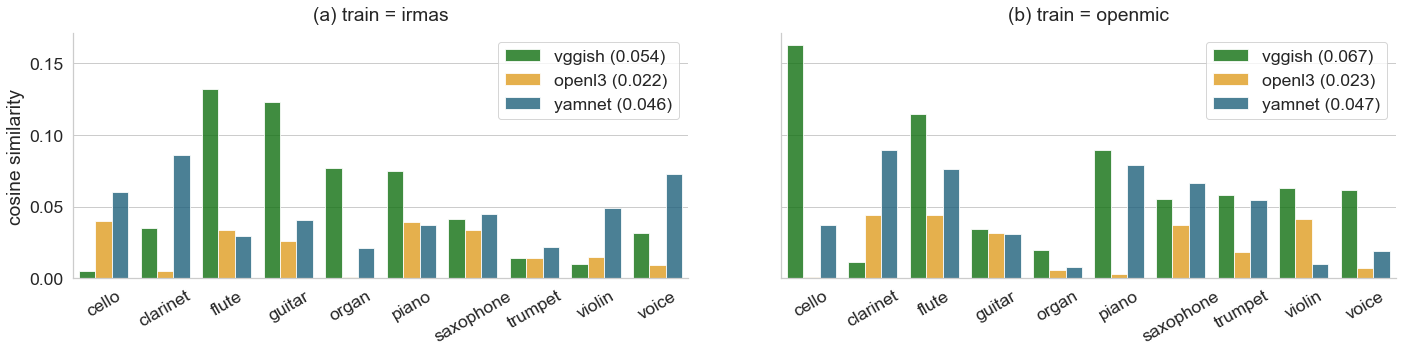

In [32]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.6)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish', 'openl3', 'yamnet']
    
df = pd.read_csv('results/cosine_similarity_original.csv')
df['cosine similarity'] = abs(df['cosine similarity'])
ax = sns.catplot(data=df, col='train set', x='instrument', y='cosine similarity', hue='embedding', kind='bar', aspect=2, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
handles, labels = a0.get_legend_handles_labels()
df_irmas = df[df['train set']=='irmas']
text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_irmas[df_irmas['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a0.legend(handles, text, ncol=1)
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")
handles, labels = a1.get_legend_handles_labels()
df_openmic = df[df['train set']=='openmic']
text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_openmic[df_openmic['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a1.legend(handles, text, ncol=1)

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.15)
ax.set_xticklabels(rotation=30)
# lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.08), ncol=3, title=None, frameon=False)
# plt.tight_layout()
plt.savefig('results/cosine_similarity_linear.pdf', bbox_inches='tight')
plt.savefig('results/cosine_similarity_linear.png', bbox_inches='tight')

## kernelized

In [33]:
project_method = '-klda'
debias_method = '-k'

cosine_sim = pd.DataFrame({'instrument': [],
                           'embedding': [],
                           'train set': [],
                          'cosine similarity': [],
                         })


for embedding in ['vggish', 'openl3', 'yamnet']:
    file = open('models/datasep_' + embedding + project_method + '.pickle', 'rb')
    globals()['LDAcoef_' + embedding] = pickle.load(file)
    file.close()
    
    # load the trained instrument classification model
    file = open('models/models_irmas_' + embedding + debias_method + '.pickle', 'rb')
    globals()['models_' + embedding + '_irmas'] = pickle.load(file)
    file.close()

    file = open('models/models_openmic_' + embedding + debias_method + '.pickle', 'rb')
    globals()['models_' + embedding + '_openmic'] = pickle.load(file)
    file.close()
    
    globals()['sim_' + embedding + '_irmas'] = []
    globals()['sim_' + embedding + '_openmic'] = []

    for key in class_align:
        globals()['sim_' + embedding + '_irmas'].append(cosine_similarity(
            globals()['models_' + embedding + '_irmas'][key].best_estimator_.coef_, globals()['LDAcoef_' + embedding])[0][0])
        globals()['sim_' + embedding + '_openmic'].append(cosine_similarity(
            globals()['models_' + embedding + '_openmic'][key].best_estimator_.coef_, globals()['LDAcoef_' + embedding])[0][0])
        
    embedding_sim = pd.DataFrame({'instrument': list(class_align.keys()) * 2,
                       'embedding': [embedding] * len(class_align) * 2,
                       'train set': ['irmas'] * len(class_align) + ['openmic'] * len(class_align),
                       'cosine similarity': globals()['sim_' + embedding + '_irmas'] + 
                                            globals()['sim_' + embedding + '_openmic']
                     })
    
    cosine_sim = cosine_sim.append(embedding_sim)
    
cosine_sim.to_csv('results/cosine_similarity_kernelized.csv', index=False)

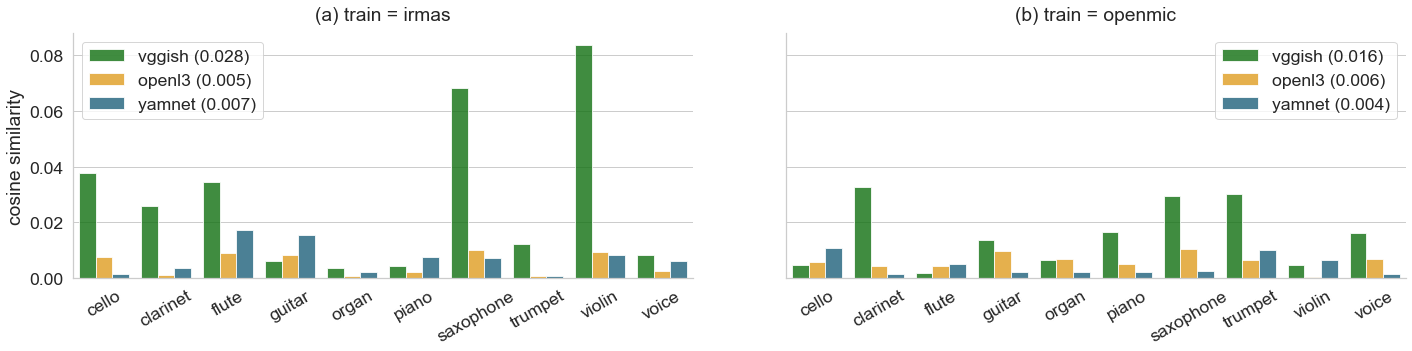

In [34]:
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.6)
colors = ['green', 'orange', '#0e668b']
hue_order = ['vggish', 'openl3', 'yamnet']
    
df = pd.read_csv('results/cosine_similarity_kernelized.csv')
df['cosine similarity'] = abs(df['cosine similarity'])
ax = sns.catplot(data=df, col='train set', x='instrument', y='cosine similarity', hue='embedding', kind='bar', aspect=2, 
               legend_out=False, palette=colors, hue_order=hue_order, alpha = 0.8)
a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
handles, labels = a0.get_legend_handles_labels()
df_irmas = df[df['train set']=='irmas']
text = [a0.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_irmas[df_irmas['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a0.legend(handles, text, ncol=1)
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")
handles, labels = a1.get_legend_handles_labels()
df_openmic = df[df['train set']=='openmic']
text = [a1.legend(ncol=1).get_texts()[l].get_text() + ' (' + \
        str(np.round(df_openmic[df_openmic['embedding']==hue_order[l]]['cosine similarity'].mean(), 3)) + ')' for l in range(len(hue_order))]
a1.legend(handles, text, ncol=1)

ax.set(xlabel=None)
plt.subplots_adjust(wspace=0.15)
ax.set_xticklabels(rotation=30)
# lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.08), ncol=3, title=None, frameon=False)
# plt.tight_layout()
plt.savefig('results/cosine_similarity_kernelized.pdf', bbox_inches='tight')
plt.savefig('results/cosine_similarity_kernelized.png', bbox_inches='tight')

# genere information

In [5]:
genre_inst = pd.read_csv('results/genre_information.csv')
genre_inst = genre_inst[((genre_inst.genre != 'other'))]
genre_inst['train set'] = genre_inst['train_set']

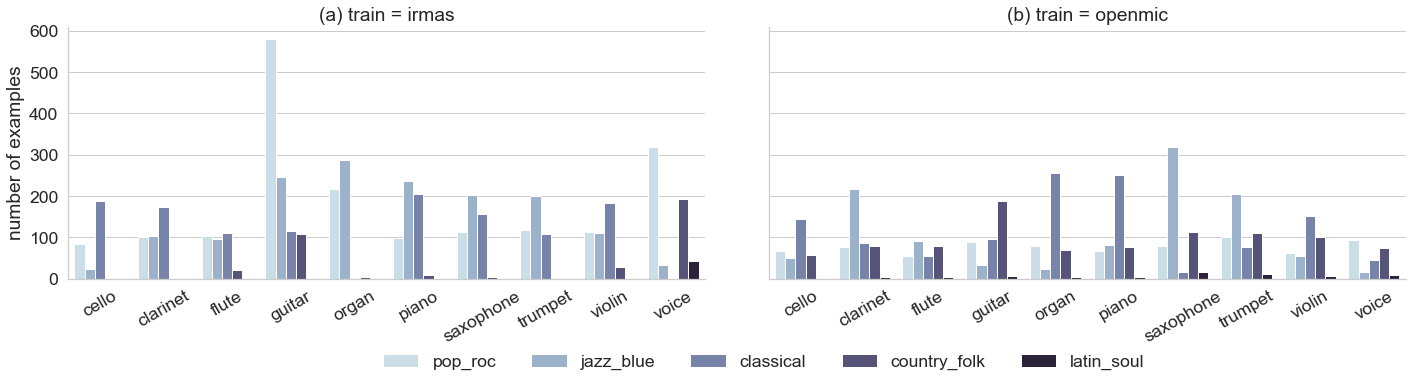

In [6]:
# save cosine similarity into a csv file
sns.set_theme(context='notebook', style='whitegrid', font_scale=1.6)

genre_inst = pd.read_csv('results/genre_information.csv')
genre_inst = genre_inst[((genre_inst.genre != 'other'))]
genre_inst['train set'] = genre_inst['train_set']
ax = sns.catplot(data=genre_inst, col='train set', x='instrument', y='examples', hue='genre', kind='bar', aspect=2, 
               legend_out=False, palette="ch:s=.25,rot=-.25")

a0 = ax.fig.axes[0]
a0.set_title("(a) train = irmas")
a1 = ax.fig.axes[1]
a1.set_title("(b) train = openmic")

ax.set(ylabel='number of examples')
ax.set(xlabel=None)
lgd = sns.move_legend(ax, "lower center", bbox_to_anchor=(.54, -.11), ncol=5, title=None, frameon=False)
plt.subplots_adjust(wspace=0.1)
ax.set_xticklabels(rotation=30)
plt.savefig('results/genre_information.pdf', bbox_inches='tight')
plt.savefig('results/genre_information.png', bbox_inches='tight')

# no bias correction (original performance)

In [35]:
def plot(ax, train_set, test_set, df, k):

    df_visual1 = df[df['test_set']==test_set]
    df = df_visual1[df_visual1['train_set']==train_set]

    dist = .3
    y = np.arange(len(class_align)) * 5 + 1.5

    color = 'green'; embedding = 'vggish'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    #######################################
    y = np.arange(len(class_align)) * 5 
    color = 'orange'; embedding = 'openl3'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    #######################################
    y = np.arange(len(class_align)) * 5 - 1.5
    color = '#0e668b'; embedding = 'yamnet'
    embedding_pair = [embedding]
    ax.scatter(y=y, x=df[df['embedding']==embedding_pair[0]][metric], color=color, alpha=0.9, marker='^', s=60, label=embedding)

    order = ['c', 'd', 'a', 'b']
    ax.set_title('(' + order[k] + ') ' + 'train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(class_align)) * 5)
    ax.set_yticklabels(list(class_align.keys())) 
    ax.set_xlabel('roc_auc')

In [36]:
result_all = pd.read_csv('results/result_all.csv')
result_all['debias_method'] = [list(result_all['embedding'])[k].replace(list(result_all['embedding'])[k].split('-')[0], '') \
                               for k in range(len(result_all['embedding']))]
result_all['embedding'] = [list(result_all['embedding'])[k].split('-')[0] \
                               for k in range(len(result_all['embedding']))]
result_all['debias_method'] = ['original' if k=='' else k for k in result_all['debias_method']] 

In [37]:
df = result_all[result_all['debias_method']=='original']
df = df.reset_index(drop=True)

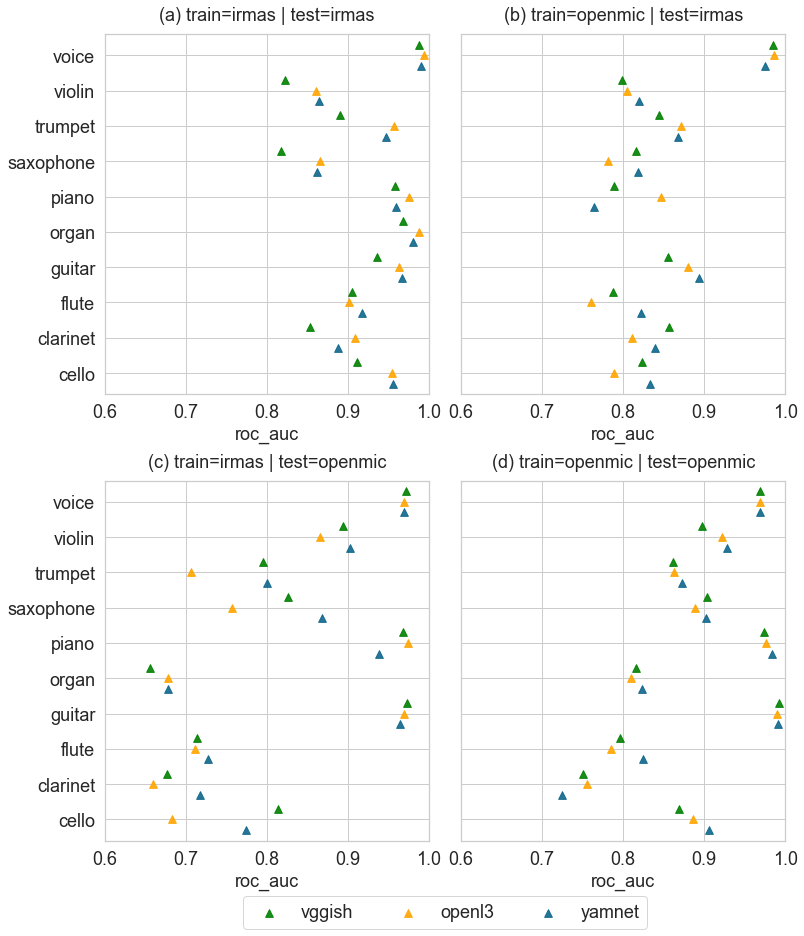

In [38]:
metric = 'roc_auc'
figure = plt.figure(figsize=(9,10))

size = 18
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

   
train_set = 'irmas'; test_set = 'openmic'; k = 0
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-3,48])

train_set = 'openmic'; test_set = 'openmic'; k = 1
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_yticklabels([]); ax.set_ylim([-3,48])
plt.legend(loc="lower center", ncol=4, bbox_to_anchor=(-0.05, -0.27)) 

train_set = 'irmas'; test_set = 'irmas'; k = 2
ax = plt.Axes(figure, [0, 0.5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-3,48])

train_set = 'openmic'; test_set = 'irmas'; k = 3
ax = plt.Axes(figure, [.5+.05, .5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_yticklabels([]); ax.set_ylim([-3,48])

plt.tight_layout(); 
plt.savefig('results/original_performance.pdf', bbox_inches = "tight"); 
# plt.savefig('crossdataset_allresults.png', bbox_inches = "tight")

# debiasing results

## version 1 - all compared to original embedding

In [39]:
def plot(ax, train_set, test_set, df, k):

    df_visual1 = df[df['train_set']==train_set]
    df = df_visual1[df_visual1['test_set']==test_set]

    dist = 1
    y = np.arange(len(class_align)) * 5 + 1.7

    color = 'green'; embedding = 'vggish'
    bias_lir = [embedding, embedding+'-lda', embedding+'-lda-genre']
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[0]][metric], color=color, alpha=.8, marker='s', label=embedding)
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[1]][metric], color=color, alpha=.8, marker='^')
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[2]][metric], color=color, alpha=.8, marker='o')
    
    bias_nonlir = [embedding+'-k', embedding+'-klda', embedding+'-klda-genre']
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[0]][metric], color=color, alpha=.8, marker='s')
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[1]][metric], color=color, alpha=.8, marker='^')
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[2]][metric], color=color, alpha=.8, marker='o')
    
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[0]][metric], xmax=df[df['embedding']==bias_lir[1]][metric],
              color=color, alpha=1, linewidth=2)
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[1]][metric], xmax=df[df['embedding']==bias_lir[2]][metric],
          color=color, alpha=1, linewidth=2)
    
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[0]][metric], xmax=df[df['embedding']==bias_nonlir[1]][metric],
              color=color, alpha=1, linewidth=2, linestyles='--')
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[1]][metric], xmax=df[df['embedding']==bias_nonlir[2]][metric],
          color=color, alpha=1, linewidth=2, linestyles='--')

    #######################################
    y = np.arange(len(class_align)) * 5 
    color = 'orange'; embedding = 'openl3'
    bias_lir = [embedding, embedding+'-lda', embedding+'-lda-genre']
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[0]][metric], color=color, alpha=.8, marker='s', label=embedding)
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[1]][metric], color=color, alpha=.8, marker='^')
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[2]][metric], color=color, alpha=.8, marker='o')
    
    bias_nonlir = [embedding+'-k', embedding+'-klda', embedding+'-klda-genre']
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[0]][metric], color=color, alpha=.8, marker='s')
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[1]][metric], color=color, alpha=.8, marker='^')
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[2]][metric], color=color, alpha=.8, marker='o')
    
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[0]][metric], xmax=df[df['embedding']==bias_lir[1]][metric],
              color=color, alpha=1, linewidth=2)
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[1]][metric], xmax=df[df['embedding']==bias_lir[2]][metric],
          color=color, alpha=1, linewidth=2)
    
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[0]][metric], xmax=df[df['embedding']==bias_nonlir[1]][metric],
              color=color, alpha=1, linewidth=2, linestyles='--')
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[1]][metric], xmax=df[df['embedding']==bias_nonlir[2]][metric],
          color=color, alpha=1, linewidth=2, linestyles='--')
    

    #######################################
    y = np.arange(len(class_align)) * 5 - 1.7
    color = '#0e668b'; embedding = 'yamnet'
    bias_lir = [embedding, embedding+'-lda', embedding+'-lda-genre']
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[0]][metric], color=color, alpha=.8, marker='s', label=embedding)
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[1]][metric], color=color, alpha=.8, marker='^')
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[2]][metric], color=color, alpha=.8, marker='o')
    
    bias_nonlir = [embedding+'-k', embedding+'-klda', embedding+'-klda-genre']
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[0]][metric], color=color, alpha=.8, marker='s', label='original')
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[1]][metric], color=color, alpha=.8, marker='^', label='global debiasing')
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[2]][metric], color=color, alpha=.8, marker='o', label='per-genre debiasing')
    
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[0]][metric], xmax=df[df['embedding']==bias_lir[1]][metric],
              color=color, alpha=1, linewidth=2)
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[1]][metric], xmax=df[df['embedding']==bias_lir[2]][metric],
          color=color, alpha=1, linewidth=2, label='linear')
    
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[0]][metric], xmax=df[df['embedding']==bias_nonlir[1]][metric],
              color=color, alpha=1, linewidth=2, linestyles='--')
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[1]][metric], xmax=df[df['embedding']==bias_nonlir[2]][metric],
          color=color, alpha=1, linewidth=2, linestyles='--', label='nonlinear')

    order = ['c', 'd', 'a', 'b']
    ax.set_title('(' + order[k] + ') ' + 'train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(class_align)) * 5)
    ax.set_yticklabels(list(class_align.keys())) 
    ax.set_xlabel('roc_auc')

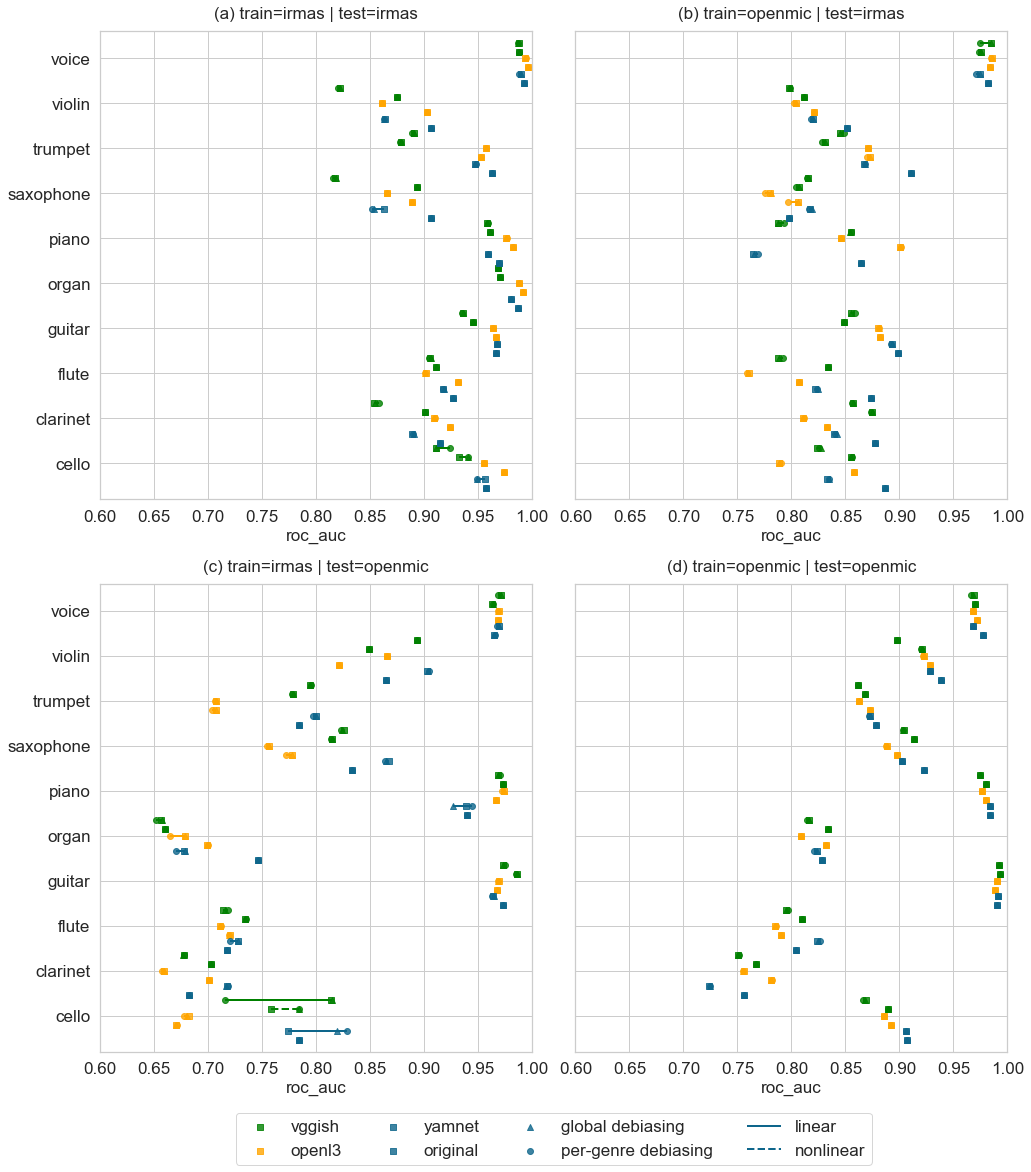

In [40]:
df = pd.read_csv('results/result_all.csv')
metric = 'roc_auc'
figure = plt.figure(figsize=(12,13))

size = 17
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

   
train_set = 'irmas'; test_set = 'openmic'; k = 0
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-4,48])

train_set = 'openmic'; test_set = 'openmic'; k = 1
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.legend(loc="lower center", ncol=4, bbox_to_anchor=(-0.05, -0.26)) 

train_set = 'irmas'; test_set = 'irmas'; k = 2
ax = plt.Axes(figure, [0, 0.5+.09, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_ylim([-4,48])

train_set = 'openmic'; test_set = 'irmas'; k = 3
ax = plt.Axes(figure, [.5+.05, .5+.09, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.6,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])

plt.tight_layout(); 
plt.savefig('results/crossdataset_allresults.pdf', bbox_inches = "tight"); 
# plt.savefig('crossdataset_allresults.png', bbox_inches = "tight")

## version 2 - all compared to original embedding

In [41]:
from matplotlib.markers import MarkerStyle
def plot(ax, train_set, test_set, df, k):

    df_visual1 = df[df['train_set']==train_set]
    df = df_visual1[df_visual1['test_set']==test_set]

    dist = 1
    y = np.arange(len(class_align)) * 5 + 1.7
    ms1 = 100 # marker size
    line_alpha = .6; linewidth = 2
    marker_alpha = .8

    color = 'green'; embedding = 'vggish'
    bias_lir = [embedding, embedding+'-lda', embedding+'-lda-genre']
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[0]][metric], alpha=.8, color=color, marker='4', s=ms1)
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[1]][metric], alpha=.8, color=color, edgecolors='face', 
               marker=MarkerStyle(marker='>', fillstyle='none'))
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[2]][metric], color=color, alpha=.8, marker='>', label=embedding)
    
    bias_nonlir = [embedding, embedding+'-klda', embedding+'-klda-genre']
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[0]][metric], alpha=.8, color=color, marker='4', s=ms1)
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[1]][metric], alpha=.8, color=color, edgecolors='face', 
               marker=MarkerStyle(marker='>', fillstyle='none'))
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[2]][metric], color=color, alpha=.8, marker='>')
    
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[0]][metric], xmax=df[df['embedding']==bias_lir[1]][metric],
              color=color, alpha=line_alpha, linewidth=linewidth)
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[1]][metric], xmax=df[df['embedding']==bias_lir[2]][metric],
          color=color, alpha=line_alpha, linewidth=linewidth)
    
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[0]][metric], xmax=df[df['embedding']==bias_nonlir[1]][metric],
              color=color, alpha=line_alpha, linewidth=linewidth, linestyles='--')
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[1]][metric], xmax=df[df['embedding']==bias_nonlir[2]][metric],
          color=color, alpha=line_alpha, linewidth=linewidth, linestyles='--')

    #######################################
    y = np.arange(len(class_align)) * 5 
    color = 'orange'; embedding = 'openl3'
    bias_lir = [embedding, embedding+'-lda', embedding+'-lda-genre']
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[0]][metric], alpha=.8, color=color, marker='4', s=ms1)
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[1]][metric], alpha=.8, color=color, edgecolors='face', 
               marker=MarkerStyle(marker='>', fillstyle='none'))
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[2]][metric], color=color, alpha=.8, marker='>',  label=embedding)
    
    bias_nonlir = [embedding, embedding+'-klda', embedding+'-klda-genre']
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[0]][metric], alpha=.8, color=color, marker='4', s=ms1)
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[1]][metric], alpha=.8, color=color, edgecolors='face', 
               marker=MarkerStyle(marker='>', fillstyle='none'))
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[2]][metric], color=color, alpha=.8, marker='>')
    
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[0]][metric], xmax=df[df['embedding']==bias_lir[1]][metric],
              color=color, alpha=line_alpha, linewidth=linewidth)
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[1]][metric], xmax=df[df['embedding']==bias_lir[2]][metric],
          color=color, alpha=line_alpha, linewidth=linewidth)
    
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[0]][metric], xmax=df[df['embedding']==bias_nonlir[1]][metric],
              color=color, alpha=line_alpha, linewidth=linewidth, linestyles='--')
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[1]][metric], xmax=df[df['embedding']==bias_nonlir[2]][metric],
          color=color, alpha=line_alpha, linewidth=linewidth, linestyles='--')
    

    #######################################
    y = np.arange(len(class_align)) * 5 - 1.7
    color = '#0e668b'; embedding = 'yamnet'
    bias_lir = [embedding, embedding+'-lda', embedding+'-lda-genre']
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[0]][metric], alpha=.8, color=color, marker='4', s=ms1)
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[1]][metric], alpha=.8, color=color, edgecolors='face', 
               marker=MarkerStyle(marker='>', fillstyle='none'))
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[2]][metric], color=color, alpha=.8, marker='>',  label=embedding)
    
    bias_nonlir = [embedding, embedding+'-klda', embedding+'-klda-genre']
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[0]][metric], alpha=.8, color=color, marker='4', s=ms1, label='original')
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[1]][metric], alpha=.8, color=color, edgecolors='face', 
               marker=MarkerStyle(marker='>', fillstyle='none'), label='global debiasing')
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[2]][metric], color=color, alpha=.8, marker='>',  label='per-genre debiasing')
    
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[0]][metric], xmax=df[df['embedding']==bias_lir[1]][metric],
              color=color, alpha=line_alpha, linewidth=linewidth)
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[1]][metric], xmax=df[df['embedding']==bias_lir[2]][metric],
          color=color, alpha=line_alpha, linewidth=linewidth, label='linear')
    
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[0]][metric], xmax=df[df['embedding']==bias_nonlir[1]][metric],
              color=color, alpha=line_alpha, linewidth=linewidth, linestyles='--')
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[1]][metric], xmax=df[df['embedding']==bias_nonlir[2]][metric],
          color=color, alpha=line_alpha, linewidth=linewidth, linestyles='--', label='nonlinear')

    order = ['c', 'd', 'a', 'b']
    ax.set_title('(' + order[k] + ') ' + 'train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(class_align)) * 5)
    ax.set_yticklabels(list(class_align.keys())) 
    ax.set_xlabel('roc_auc')

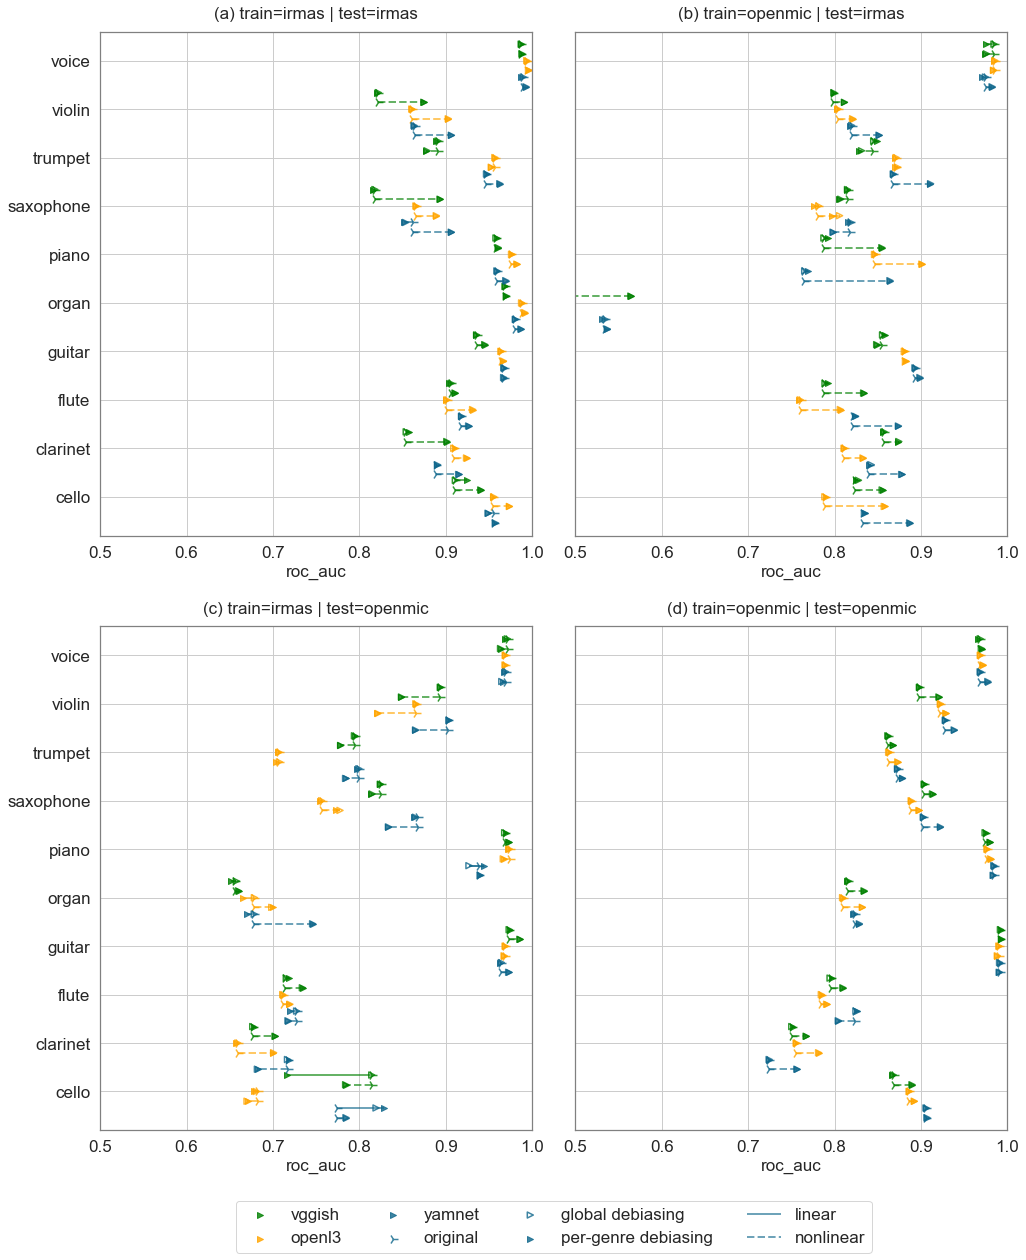

In [42]:
df = pd.read_csv('results/result_all.csv')
metric = 'roc_auc'
figure = plt.figure(figsize=(12,14))

size = 17
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.edgecolor': 'grey',
          'axes.titlepad': size*.75}
plt.rcParams.update(params)
  
train_set = 'irmas'; test_set = 'openmic'; k = 0
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.5,1]); ax.set_ylim([-4,48])
plt.grid(True)

train_set = 'openmic'; test_set = 'openmic'; k = 1
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.5,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.legend(loc="lower center", ncol=4, bbox_to_anchor=(-0.05, -0.26)) 
plt.grid(True)

train_set = 'irmas'; test_set = 'irmas'; k = 2
ax = plt.Axes(figure, [0, 0.5+.09, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.5,1]); ax.set_ylim([-4,48])
plt.grid(True)

train_set = 'openmic'; test_set = 'irmas'; k = 3
ax = plt.Axes(figure, [.5+.05, .5+.09, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.5,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])

plt.tight_layout(); 
plt.grid(True)
plt.savefig('results/crossdataset_allresults.pdf', bbox_inches = "tight"); 
plt.savefig('results/crossdataset_allresults.png', bbox_inches = "tight")

## version 2 - linear compared to original embedding, nonlinear compared to kernelized embedding

In [10]:
from matplotlib.markers import MarkerStyle
def plot(ax, train_set, test_set, df, k):

    df_visual1 = df[df['train_set']==train_set]
    df = df_visual1[df_visual1['test_set']==test_set]

    dist = 1
    y = np.arange(len(class_align)) * 5 + 1.7
    ms1 = 100 # marker size
    line_alpha = .6; linewidth = 2
    marker_alpha = .8

    color = 'green'; embedding = 'vggish'
    bias_lir = [embedding, embedding+'-lda', embedding+'-lda-genre']
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[0]][metric], alpha=.8, color=color, marker='4', s=ms1)
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[1]][metric], alpha=.8, color=color, edgecolors='face', 
               marker=MarkerStyle(marker='>', fillstyle='none'))
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[2]][metric], color=color, alpha=.8, marker='>', label=embedding)
    
    bias_nonlir = [embedding+'-k', embedding+'-klda', embedding+'-klda-genre']
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[0]][metric], alpha=.8, color=color, marker='4', s=ms1)
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[1]][metric], alpha=.8, color=color, edgecolors='face', 
               marker=MarkerStyle(marker='>', fillstyle='none'))
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[2]][metric], color=color, alpha=.8, marker='>')
    
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[0]][metric], xmax=df[df['embedding']==bias_lir[1]][metric],
              color=color, alpha=line_alpha, linewidth=linewidth)
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[1]][metric], xmax=df[df['embedding']==bias_lir[2]][metric],
          color=color, alpha=line_alpha, linewidth=linewidth)
    
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[0]][metric], xmax=df[df['embedding']==bias_nonlir[1]][metric],
              color=color, alpha=line_alpha, linewidth=linewidth, linestyles='--')
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[1]][metric], xmax=df[df['embedding']==bias_nonlir[2]][metric],
          color=color, alpha=line_alpha, linewidth=linewidth, linestyles='--')

    #######################################
    y = np.arange(len(class_align)) * 5 
    color = 'orange'; embedding = 'openl3'
    bias_lir = [embedding, embedding+'-lda', embedding+'-lda-genre']
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[0]][metric], alpha=.8, color=color, marker='4', s=ms1)
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[1]][metric], alpha=.8, color=color, edgecolors='face', 
               marker=MarkerStyle(marker='>', fillstyle='none'))
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[2]][metric], color=color, alpha=.8, marker='>',  label=embedding)
    
    bias_nonlir = [embedding+'-k', embedding+'-klda', embedding+'-klda-genre']
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[0]][metric], alpha=.8, color=color, marker='4', s=ms1)
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[1]][metric], alpha=.8, color=color, edgecolors='face', 
               marker=MarkerStyle(marker='>', fillstyle='none'))
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[2]][metric], color=color, alpha=.8, marker='>')
    
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[0]][metric], xmax=df[df['embedding']==bias_lir[1]][metric],
              color=color, alpha=line_alpha, linewidth=linewidth)
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[1]][metric], xmax=df[df['embedding']==bias_lir[2]][metric],
          color=color, alpha=line_alpha, linewidth=linewidth)
    
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[0]][metric], xmax=df[df['embedding']==bias_nonlir[1]][metric],
              color=color, alpha=line_alpha, linewidth=linewidth, linestyles='--')
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[1]][metric], xmax=df[df['embedding']==bias_nonlir[2]][metric],
          color=color, alpha=line_alpha, linewidth=linewidth, linestyles='--')
    

    #######################################
    y = np.arange(len(class_align)) * 5 - 1.7
    color = '#0e668b'; embedding = 'yamnet'
    bias_lir = [embedding, embedding+'-lda', embedding+'-lda-genre']
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[0]][metric], alpha=.8, color=color, marker='4', s=ms1)
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[1]][metric], alpha=.8, color=color, edgecolors='face', 
               marker=MarkerStyle(marker='>', fillstyle='none'))
    ax.scatter(y=y, x=df[df['embedding']==bias_lir[2]][metric], color=color, alpha=.8, marker='>',  label=embedding)
    
    bias_nonlir = [embedding+'-k', embedding+'-klda', embedding+'-klda-genre']
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[0]][metric], alpha=.8, color=color, marker='4', s=ms1, label='original')
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[1]][metric], alpha=.8, color=color, edgecolors='face', 
               marker=MarkerStyle(marker='>', fillstyle='none'), label='global debiasing')
    ax.scatter(y=y-dist, x=df[df['embedding']==bias_nonlir[2]][metric], color=color, alpha=.8, marker='>',  label='per-genre debiasing')
    
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[0]][metric], xmax=df[df['embedding']==bias_lir[1]][metric],
              color=color, alpha=line_alpha, linewidth=linewidth)
    ax.hlines(y=y, xmin=df[df['embedding']==bias_lir[1]][metric], xmax=df[df['embedding']==bias_lir[2]][metric],
          color=color, alpha=line_alpha, linewidth=linewidth, label='linear')
    
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[0]][metric], xmax=df[df['embedding']==bias_nonlir[1]][metric],
              color=color, alpha=line_alpha, linewidth=linewidth, linestyles='--')
    ax.hlines(y=y-dist, xmin=df[df['embedding']==bias_nonlir[1]][metric], xmax=df[df['embedding']==bias_nonlir[2]][metric],
          color=color, alpha=line_alpha, linewidth=linewidth, linestyles='--', label='nonlinear')

    order = ['c', 'd', 'a', 'b']
    ax.set_title('(' + order[k] + ') ' + 'train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(class_align)) * 5)
    ax.set_yticklabels(list(class_align.keys())) 
    ax.set_xlabel('roc_auc')

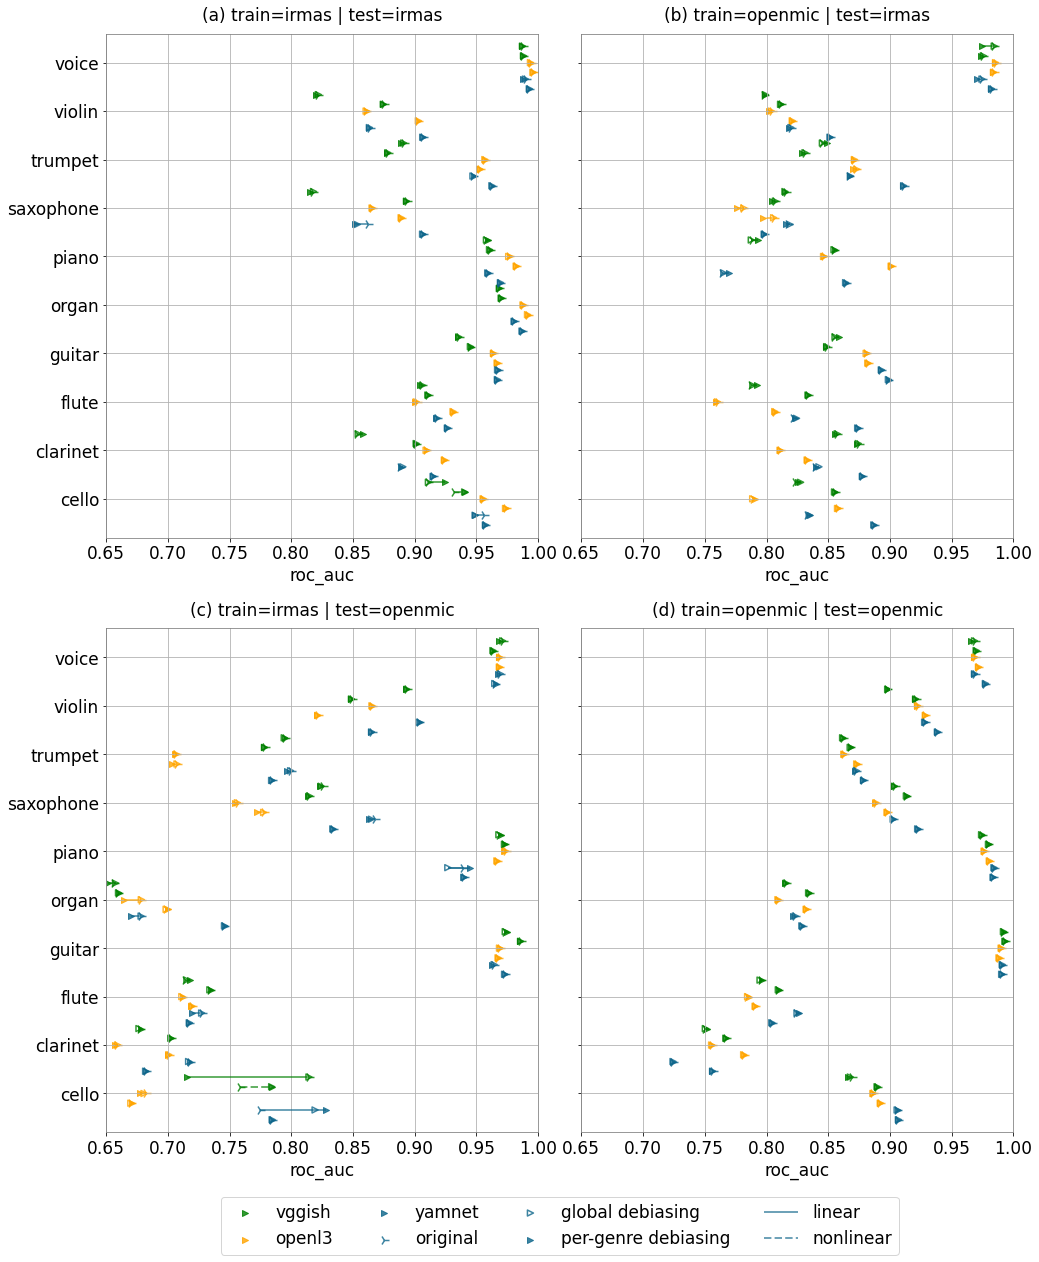

In [11]:
df = pd.read_csv('results/result_all.csv')
metric = 'roc_auc'
figure = plt.figure(figsize=(12,14))

size = 17
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.edgecolor': 'grey',
          'axes.titlepad': size*.75}
plt.rcParams.update(params)
  
train_set = 'irmas'; test_set = 'openmic'; k = 0
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.65,1]); ax.set_ylim([-4,48])
plt.grid(True)

train_set = 'openmic'; test_set = 'openmic'; k = 1
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.65,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.legend(loc="lower center", ncol=4, bbox_to_anchor=(-0.05, -0.26)) 
plt.grid(True)

train_set = 'irmas'; test_set = 'irmas'; k = 2
ax = plt.Axes(figure, [0, 0.5+.09, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.65,1]); ax.set_ylim([-4,48])
plt.grid(True)

train_set = 'openmic'; test_set = 'irmas'; k = 3
ax = plt.Axes(figure, [.5+.05, .5+.09, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, k); ax.set_xlim([0.65,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])

plt.tight_layout(); 
plt.grid(True)
plt.savefig('results/crossdataset_allresults.pdf', bbox_inches = "tight"); 
plt.savefig('results/crossdataset_allresults.png', bbox_inches = "tight")

## version 3 - wedge connector

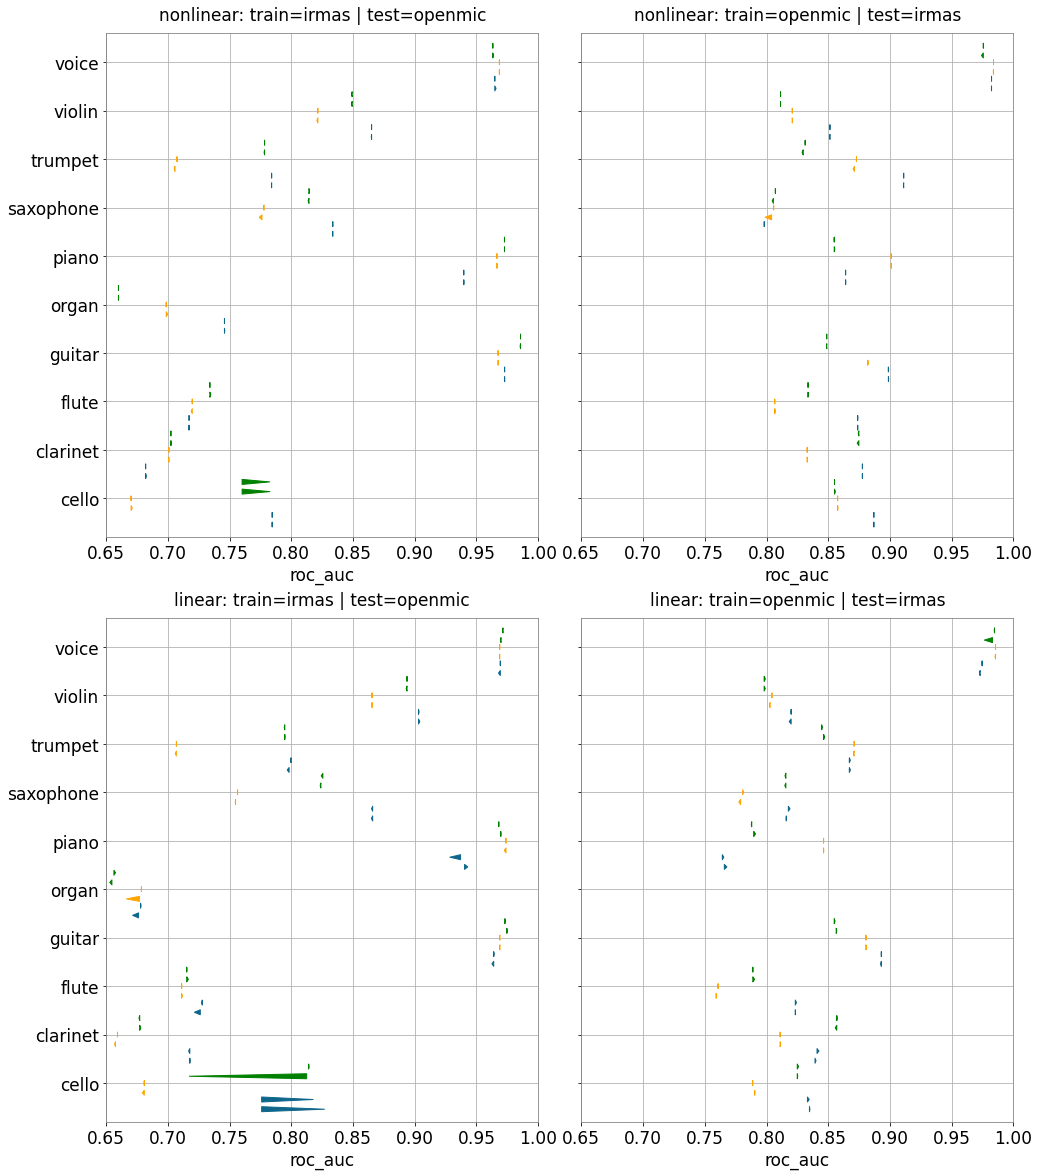

In [14]:
from matplotlib.markers import MarkerStyle
def plot(ax, train_set, test_set, df, lir_nonlir):

    df_visual1 = df[df['train_set']==train_set]
    df = df_visual1[df_visual1['test_set']==test_set]
    
    dist = 1
    ms1 = 20 # marker size
    line_alpha = .6; linewidth = 2
    marker_alpha = .8

    embedding_color = [('vggish', 'green'), ('openl3', 'orange'), ('yamnet', '#0e668b')]
    y_mebedding = {'vggish': np.arange(len(class_align)) * 5 + 1.7,
                   'openl3': np.arange(len(class_align)) * 5,
                   'yamnet': np.arange(len(class_align)) * 5 - 1.7}
           
    for embedding, color in embedding_color:
        y = y_mebedding[embedding]
        if lir_nonlir == 'linear':
            bias_lir_nonlir = [embedding, embedding+'-lda', embedding+'-lda-genre']
        else:
            bias_lir_nonlir = [embedding+'-k', embedding+'-klda', embedding+'-klda-genre']      
            
        x = list(df[df['embedding']==bias_lir_nonlir[1]][metric])
#         ax.scatter(y=y, x=x, alpha=.8, color=color, marker='.', s=ms1, label=embedding)
        for mark in range(len(y)):
            ax.annotate('', (x[mark], y[mark]), 
                    xytext=(list(df[df['embedding']==bias_lir_nonlir[0]][metric])[mark], y[mark]), 
                        arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

        y = y - dist
        x = list(df[df['embedding']==bias_lir_nonlir[2]][metric])
#         ax.scatter(y=y, x=x, alpha=.8, color=color, marker='.', s=ms1, label=embedding)
        for mark in range(len(y)):
            ax.annotate('', (x[mark], y[mark]), 
                    xytext=(list(df[df['embedding']==bias_lir_nonlir[0]][metric])[mark], y[mark]), 
                        arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

    ax.set_title(lir_nonlir + ': train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(class_align)) * 5)
    ax.set_yticklabels(list(class_align.keys())) 
    ax.set_xlabel('roc_auc')
    
df = pd.read_csv('results/result_all.csv')
metric = 'roc_auc'
figure = plt.figure(figsize=(12,14))

size = 17
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.edgecolor': 'grey',
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

train_set = 'irmas'; test_set = 'openmic';
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_ylim([-4,48]);
plt.grid(True)

train_set = 'openmic'; test_set = 'irmas'; 
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([0.65,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.grid(True)

train_set = 'irmas'; test_set = 'openmic'; 
ax = plt.Axes(figure, [0, 0.5+.08, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'nonlinear'); ax.set_xlim([0.65,1]); ax.set_ylim([-4,48]); 
plt.grid(True)

train_set = 'openmic'; test_set = 'irmas'; 
ax = plt.Axes(figure, [.5+.05, .5+.08, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'nonlinear'); ax.set_xlim([0.65,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.grid(True)

plt.tight_layout(); 
plt.savefig('results/crossdataset_allresults.pdf', bbox_inches = "tight"); 
plt.savefig('results/crossdataset_allresults.png', bbox_inches = "tight")

## version 4 - only difference

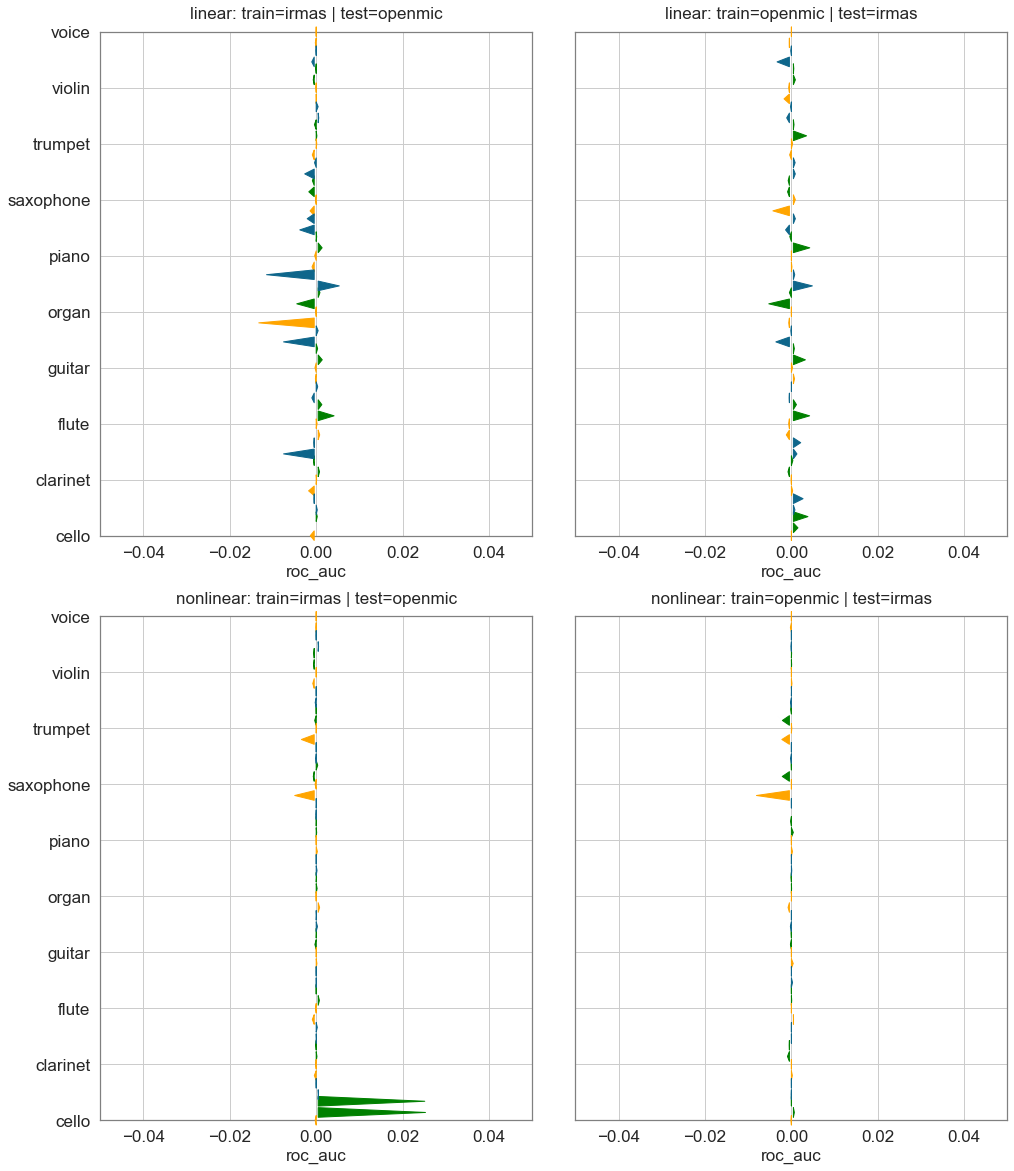

In [43]:
from matplotlib.markers import MarkerStyle
def plot(ax, train_set, test_set, df, lir_nonlir):

    df_visual1 = df[df['train_set']==train_set]
    df = df_visual1[df_visual1['test_set']==test_set]
    
    dist = 1
    ms1 = 100 # marker size
    line_alpha = .6; linewidth = 2
    marker_alpha = .8

    embedding_color = [('vggish', 'green'), ('openl3', 'orange'), ('yamnet', '#0e668b')]
    y_mebedding = {'vggish': np.arange(len(class_align)) * 5 + 1.7,
                   'openl3': np.arange(len(class_align)) * 5,
                   'yamnet': np.arange(len(class_align)) * 5 - 1.7}
           
    for embedding, color in embedding_color:
        y = y_mebedding[embedding]
        if lir_nonlir == 'linear':
            bias_lir_nonlir = [embedding, embedding+'-lda', embedding+'-lda-genre']
        else:
            bias_lir_nonlir = [embedding+'-k', embedding+'-klda', embedding+'-klda-genre']      
            
        x = np.array(list(df[df['embedding']==bias_lir_nonlir[1]][metric])) - \
            np.array(list(df[df['embedding']==bias_lir_nonlir[0]][metric]))
#         ax.scatter(y=y, x=x, alpha=.8, color=color, marker='.', s=ms1, label=embedding)
        for mark in range(len(y)):
            ax.annotate('', (x[mark], y[mark]), 
                    xytext=(np.zeros(len(x))[mark], y[mark]), 
                        arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

        y = y - dist
        x = np.array(list(df[df['embedding']==bias_lir_nonlir[2]][metric])) - \
            np.array(list(df[df['embedding']==bias_lir_nonlir[0]][metric]))
#         ax.scatter(y=y, x=x, alpha=.8, color=color, marker='.', s=ms1, label=embedding)
        for mark in range(len(y)):
            ax.annotate('', (x[mark], y[mark]), 
                    xytext=(np.zeros(len(x))[mark], y[mark]), 
                        arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

    ax.set_title(lir_nonlir + ': train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(class_align)) * 5)
    ax.set_yticklabels(list(class_align.keys())) 
    ax.set_xlabel('roc_auc')
    
df = pd.read_csv('results/result_all.csv')
metric = 'roc_auc'
figure = plt.figure(figsize=(12,14))

size = 17
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.edgecolor': 'grey',
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

train_set = 'irmas'; test_set = 'openmic';
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'nonlinear'); ax.set_xlim([-.05, .05])
plt.grid(True)

train_set = 'openmic'; test_set = 'irmas'; 
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'nonlinear'); ax.set_yticklabels([]);ax.set_xlim([-.05, .05])
plt.grid(True)

train_set = 'irmas'; test_set = 'openmic'; 
ax = plt.Axes(figure, [0, 0.5+.08, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([-.05, .05]); 
plt.grid(True)

train_set = 'openmic'; test_set = 'irmas'; 
ax = plt.Axes(figure, [.5+.05, .5+.08, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_yticklabels([]); ax.set_xlim([-.05, .05])
plt.grid(True)

plt.tight_layout(); 
plt.savefig('results/crossdataset_allresults.pdf', bbox_inches = "tight"); 
plt.savefig('results/crossdataset_allresults.png', bbox_inches = "tight")

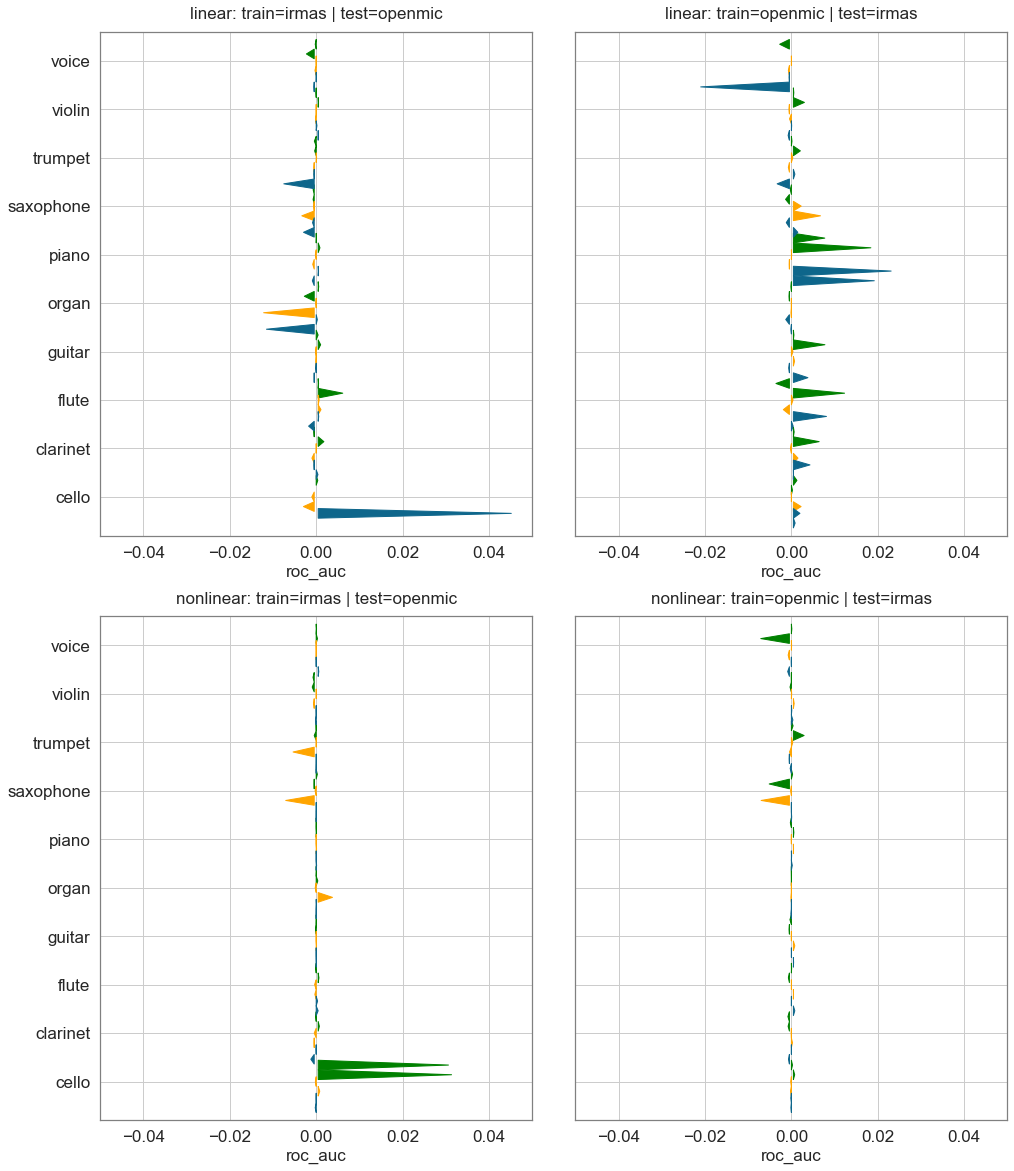

In [45]:
from matplotlib.markers import MarkerStyle
def plot(ax, train_set, test_set, df, lir_nonlir):

    df_visual1 = df[df['train_set']==train_set]
    df = df_visual1[df_visual1['test_set']==test_set]
    
    dist = 1
    ms1 = 100 # marker size
    line_alpha = .6; linewidth = 2
    marker_alpha = .8

    embedding_color = [('vggish', 'green'), ('openl3', 'orange'), ('yamnet', '#0e668b')]
    y_mebedding = {'vggish': np.arange(len(class_align)) * 5 + 1.7,
                   'openl3': np.arange(len(class_align)) * 5,
                   'yamnet': np.arange(len(class_align)) * 5 - 1.7}
           
    for embedding, color in embedding_color:
        y = y_mebedding[embedding]
        if lir_nonlir == 'linear':
            bias_lir_nonlir = [embedding, embedding+'-lda', embedding+'-lda-genre']
        else:
            bias_lir_nonlir = [embedding+'-k', embedding+'-klda', embedding+'-klda-genre']      
            
        x = np.array(list(df[df['embedding']==bias_lir_nonlir[1]][metric])) - \
            np.array(list(df[df['embedding']==bias_lir_nonlir[0]][metric]))
#         ax.scatter(y=y, x=x, alpha=.8, color=color, marker='.', s=ms1, label=embedding)
        for mark in range(len(y)):
            ax.annotate('', (x[mark], y[mark]), 
                    xytext=(np.zeros(len(x))[mark], y[mark]), 
                        arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

        y = y - dist
        x = np.array(list(df[df['embedding']==bias_lir_nonlir[2]][metric])) - \
            np.array(list(df[df['embedding']==bias_lir_nonlir[0]][metric]))
#         ax.scatter(y=y, x=x, alpha=.8, color=color, marker='.', s=ms1, label=embedding)
        for mark in range(len(y)):
            ax.annotate('', (x[mark], y[mark]), 
                    xytext=(np.zeros(len(x))[mark], y[mark]), 
                        arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

    ax.set_title(lir_nonlir + ': train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(class_align)) * 5)
    ax.set_yticklabels(list(class_align.keys())) 
    ax.set_xlabel('roc_auc')
    
df = pd.read_csv('results/result_all.csv')
metric = 'ap'
figure = plt.figure(figsize=(12,14))

size = 17
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.edgecolor': 'grey',
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

train_set = 'irmas'; test_set = 'openmic';
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'nonlinear'); ax.set_xlim([-.05, .05]); ax.set_ylim([-4,48])
plt.grid(True)

train_set = 'openmic'; test_set = 'irmas'; 
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'nonlinear'); ax.set_yticklabels([]);ax.set_xlim([-.05, .05]); ax.set_ylim([-4,48])
plt.grid(True)

train_set = 'irmas'; test_set = 'openmic'; 
ax = plt.Axes(figure, [0, 0.5+.08, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_xlim([-.05, .05]); ax.set_ylim([-4,48])

train_set = 'openmic'; test_set = 'irmas'; 
ax = plt.Axes(figure, [.5+.05, .5+.08, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'linear'); ax.set_yticklabels([]); ax.set_xlim([-.05, .05]); ax.set_ylim([-4,48])
plt.grid(True)

plt.tight_layout(); 
plt.savefig('results/crossdataset_allresults.pdf', bbox_inches = "tight"); 
plt.savefig('results/crossdataset_allresults.png', bbox_inches = "tight")

# statistics 

## mean roc_auc over all instruments

In [16]:
df = pd.read_csv('results/result_all.csv')
col = ['embedding', 'train_set', 'test_set', 'roc_auc', 'ap', 'debias']
df_stat =  pd.DataFrame(columns = col)

for embedding in df.embedding.unique():
    train = 'irmas'; test = 'irmas'
    mask = (df['embedding'] == embedding) & (df['train_set'] == train) & (df['test_set'] == test)
    roc_ap = list(df.loc[mask, ['roc_auc', 'ap']].mean())
    df_stat.loc[len(df_stat)] = [embedding, train, test] + roc_ap + [None]
    
    train = 'openmic'; test = 'openmic'
    mask = (df['embedding'] == embedding) & (df['train_set'] == train) & (df['test_set'] == test)
    roc_ap = list(df.loc[mask, ['roc_auc', 'ap']].mean())
    df_stat.loc[len(df_stat)] = [embedding, train, test] + roc_ap + [None]
    
    train = 'irmas'; test = 'openmic'
    mask = (df['embedding'] == embedding) & (df['train_set'] == train) & (df['test_set'] == test)
    roc_ap = list(df.loc[mask, ['roc_auc', 'ap']].mean())
    df_stat.loc[len(df_stat)] = [embedding, train, test] + roc_ap + [None]
    
    train = 'openmic'; test = 'irmas'
    mask = (df['embedding'] == embedding) & (df['train_set'] == train) & (df['test_set'] == test)
    roc_ap = list(df.loc[mask, ['roc_auc', 'ap']].mean())
    df_stat.loc[len(df_stat)] = [embedding, train, test] + roc_ap + [None]

In [17]:
for k in range(len(df_stat)):
    for embedding in ['vggish', 'openl3', 'yamnet']:
        if embedding in df_stat['embedding'][k]:
            df_stat['debias'][k] = df_stat['embedding'][k].replace(embedding,'')
            df_stat['embedding'][k] = embedding
            
mask = (df_stat['debias'] == '')
df_stat.loc[mask, ['debias']] = 'original'

In [18]:
df_stat_order = pd.DataFrame(['embedding', 'train_set', 'test_set', 'roc_auc', 'ap', 'debias'])
debias_in_order = ['original', '-lda', '-lda-genre', '-k', '-klda', '-klda-genre']
for debias in debias_in_order:
    df_stat_order = df_stat_order.append(df_stat[df_stat['debias'] == debias])

(0.75, 0.98)

<Figure size 1152x1152 with 0 Axes>

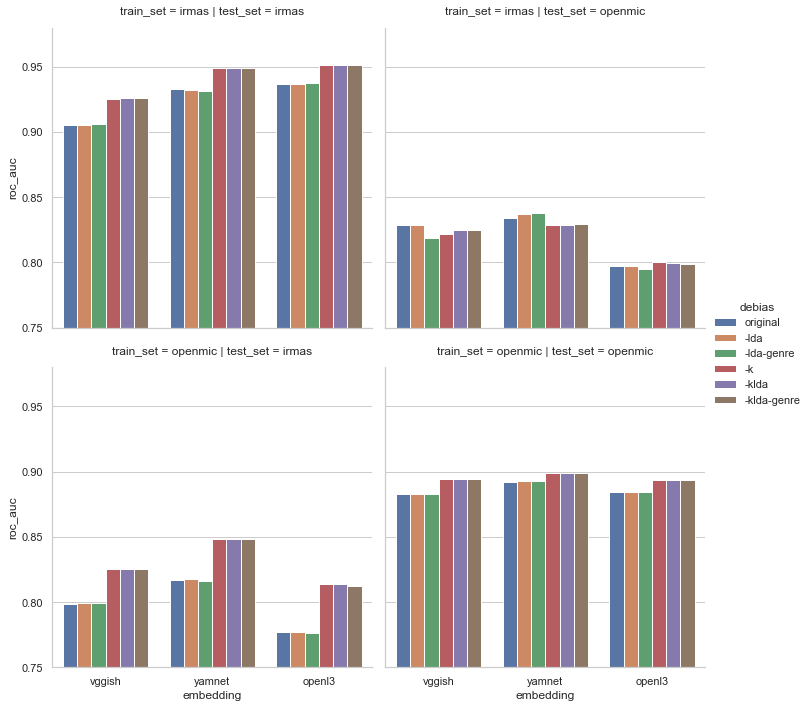

In [19]:
plt.figure(figsize=(16,16))
sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df_stat_order, row='train_set', col='test_set', y='roc_auc', x='embedding', hue='debias', kind='bar');
plt.ylim(.75, .98)

## change of mean roc_auc (all compared to original embedding)

In [20]:
df_stat = df_stat_order

In [21]:
# only plot changes
df_stat_ch = df_stat.copy()
df_stat_ch1 = df_stat_ch.copy()

for embedding in ['vggish', 'openl3', 'yamnet']:
    train = 'irmas'; test = 'irmas'
    mask = (df_stat['embedding'] == embedding) & (df_stat['train_set'] == train) & (df_stat['test_set'] == test)
    mask1 = (df_stat['embedding'] == embedding) & (df_stat['train_set'] == train) & (df_stat['test_set'] == test) & \
        (df_stat['debias'] == 'original')
    df_stat_ch.loc[mask, ['roc_auc']] = df_stat_ch1.loc[mask, ['roc_auc']] - list(df_stat_ch1.loc[mask1, ['roc_auc']]['roc_auc'])[0]
    
    train = 'openmic'; test = 'openmic'
    mask = (df_stat['embedding'] == embedding) & (df_stat['train_set'] == train) & (df_stat['test_set'] == test)
    mask1 = (df_stat['embedding'] == embedding) & (df_stat['train_set'] == train) & (df_stat['test_set'] == test) & \
        (df_stat['debias'] == 'original')
    df_stat_ch.loc[mask, ['roc_auc']] = df_stat_ch1.loc[mask, ['roc_auc']] - list(df_stat_ch1.loc[mask1, ['roc_auc']]['roc_auc'])[0]
    
    train = 'irmas'; test = 'openmic'
    mask = (df_stat['embedding'] == embedding) & (df_stat['train_set'] == train) & (df_stat['test_set'] == test)
    mask1 = (df_stat['embedding'] == embedding) & (df_stat['train_set'] == train) & (df_stat['test_set'] == test) & \
        (df_stat['debias'] == 'original')
    df_stat_ch.loc[mask, ['roc_auc']] = df_stat_ch1.loc[mask, ['roc_auc']] - list(df_stat_ch1.loc[mask1, ['roc_auc']]['roc_auc'])[0]
    
    train = 'openmic'; test = 'irmas'
    mask = (df_stat['embedding'] == embedding) & (df_stat['train_set'] == train) & (df_stat['test_set'] == test)
    mask1 = (df_stat['embedding'] == embedding) & (df_stat['train_set'] == train) & (df_stat['test_set'] == test) & \
        (df_stat['debias'] == 'original')
    df_stat_ch.loc[mask, ['roc_auc']] = df_stat_ch1.loc[mask, ['roc_auc']] - list(df_stat_ch1.loc[mask1, ['roc_auc']]['roc_auc'])[0]

<Figure size 1152x1152 with 0 Axes>

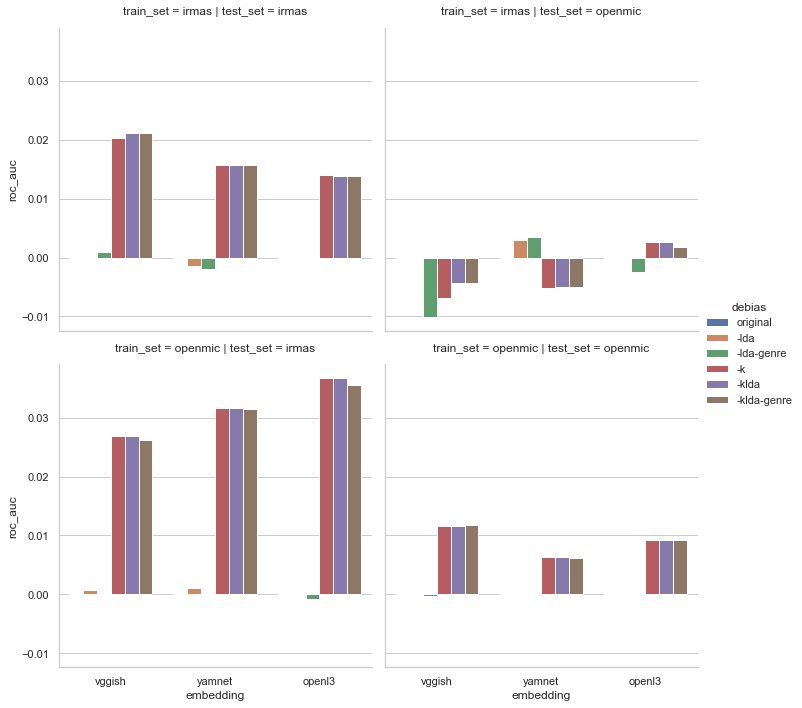

In [22]:
plt.figure(figsize=(16,16))
sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df_stat_ch, row='train_set', col='test_set', y='roc_auc', x='embedding', hue='debias', kind='bar');

## change of mean roc_auc (linear compared to original embedding, nonlinear compared kernelized embedding)

In [23]:
df_stat_ch = pd.DataFrame(columns=list(df_stat_order.columns))
df_stat = df_stat.copy()

In [24]:
# only plot changes

for embedding in ['vggish', 'openl3', 'yamnet']:
    train = 'irmas'; test = 'irmas'
    mask = (df_stat['embedding'] == embedding) & (df_stat['train_set'] == train) & (df_stat['test_set'] == test)
    temp = df_stat.loc[mask].reset_index(drop=True)
    temp_ori = temp.copy()
    for k in range(len(temp)):
        if '-k' in temp['debias'][k]:
            temp['roc_auc'][k] = temp['roc_auc'][k] - list(temp_ori[temp_ori['debias'] == '-k']['roc_auc'])[0]
        else:
            temp['roc_auc'][k] = temp['roc_auc'][k] - list(temp_ori[temp_ori['debias'] == 'original']['roc_auc'])[0]
    df_stat_ch = df_stat_ch.append(temp)
    
    train = 'openmic'; test = 'openmic'
    mask = (df_stat['embedding'] == embedding) & (df_stat['train_set'] == train) & (df_stat['test_set'] == test)
    temp = df_stat.loc[mask].reset_index(drop=True)
    temp_ori = temp.copy()
    for k in range(len(temp)):
        if '-k' in temp['debias'][k]:
            temp['roc_auc'][k] = temp['roc_auc'][k] - list(temp_ori[temp_ori['debias'] == '-k']['roc_auc'])[0]
        else:
            temp['roc_auc'][k] = temp['roc_auc'][k] - list(temp_ori[temp_ori['debias'] == 'original']['roc_auc'])[0]
    df_stat_ch = df_stat_ch.append(temp)
    
    train = 'irmas'; test = 'openmic'
    mask = (df_stat['embedding'] == embedding) & (df_stat['train_set'] == train) & (df_stat['test_set'] == test)
    temp = df_stat.loc[mask].reset_index(drop=True)
    temp_ori = temp.copy()
    for k in range(len(temp)):
        if '-k' in temp['debias'][k]:
            temp['roc_auc'][k] = temp['roc_auc'][k] - list(temp_ori[temp_ori['debias'] == '-k']['roc_auc'])[0]
        else:
            temp['roc_auc'][k] = temp['roc_auc'][k] - list(temp_ori[temp_ori['debias'] == 'original']['roc_auc'])[0]
    df_stat_ch = df_stat_ch.append(temp)
    
    train = 'openmic'; test = 'irmas'
    mask = (df_stat['embedding'] == embedding) & (df_stat['train_set'] == train) & (df_stat['test_set'] == test)
    temp = df_stat.loc[mask].reset_index(drop=True)
    temp_ori = temp.copy()
    for k in range(len(temp)):
        if '-k' in temp['debias'][k]:
            temp['roc_auc'][k] = temp['roc_auc'][k] - list(temp_ori[temp_ori['debias'] == '-k']['roc_auc'])[0]
        else:
            temp['roc_auc'][k] = temp['roc_auc'][k] - list(temp_ori[temp_ori['debias'] == 'original']['roc_auc'])[0]
    df_stat_ch = df_stat_ch.append(temp)

<Figure size 1152x1152 with 0 Axes>

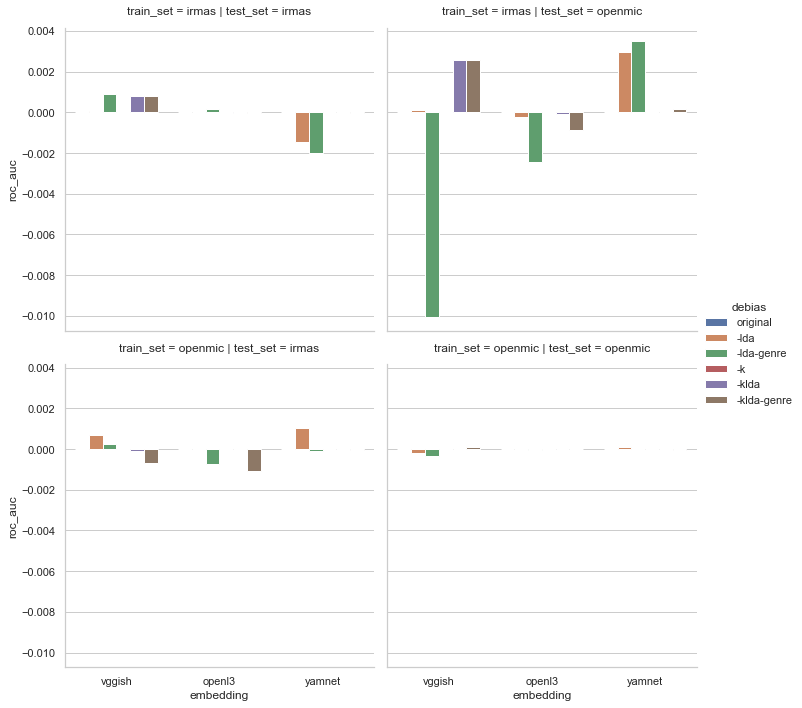

In [25]:
plt.figure(figsize=(16,16))
sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df_stat_ch, row='train_set', col='test_set', y='roc_auc', x='embedding', hue='debias', kind='bar');

# model parameters

In [26]:
# quick check of C occurences for classifiers
import pickle
import glob
import collections

x = glob.glob('models/*.pickle')

C_embedding = {'vggish': [], 'openl3': [], 'yamnet': []}

for model_file in x:
    file = open(model_file, 'rb')
    model = pickle.load(file)
    for embedding in C_embedding:
        if embedding in model_file and 'kernelizer' not in model_file and isinstance(model, dict):
            C_embedding[embedding].extend([model[inst].best_estimator_.C for inst in model])
    file.close()
    
for embedding in C_embedding:
    print(collections.Counter(C_embedding[embedding]))

Counter({10: 46, 0.1: 24, 0.01: 18, 1: 9, 1e-10: 6, 1e-05: 4, 1e-06: 3, 0.0001: 3, 0.001: 3, 100: 3, 1e-07: 1})
Counter({10: 36, 0.01: 36, 100: 21, 0.1: 18, 0.0001: 3, 1: 3, 1e-05: 3})
Counter({10: 36, 1: 15, 1e-05: 15, 0.001: 15, 0.01: 12, 0.1: 6, 100: 6, 1e-06: 5, 1e-10: 4, 0.0001: 4, 1e-09: 1, 1e-08: 1})


In [27]:
# check C in each case
import re
import glob
import pickle

x = glob.glob('models/models_*.pickle')

C_embedding = {'vggish': [], 'openl3': [], 'yamnet': []}
for embedding in C_embedding:
    C_embedding[embedding] = pd.DataFrame(columns= list(class_align.keys()) + ['debias_methods'] + ['train_set'])

for model_file in x:
    file = open(model_file, 'rb')
    model = pickle.load(file)
    for embedding in C_embedding:
        if embedding in model_file:
            debias_methods = re.search(embedding + '(.*).pickle', model_file).group(1)
            train_set = re.search('models_(.*)_' + embedding, model_file).group(1)
            if debias_methods == '': debias_methods = 'original'
            C_embedding[embedding].loc[len(C_embedding[embedding])] = \
            [model[inst].best_estimator_.C for inst in list(class_align.keys())] + [debias_methods] + [train_set]
    file.close()

In [28]:
C_embedding['vggish']

,cello,clarinet,flute,guitar,organ,piano,saxophone,trumpet,violin,voice,debias_methods,train_set
0,1.000000e-10,1.000000e-06,0.01,0.10,1.000000e-02,0.10,0.00001,0.0001,1.000000e-10,0.1,-lda,irmas
1,1.000000e-01,1.000000e-01,0.01,0.01,1.000000e-06,0.01,0.10000,0.1000,1.000000e-03,0.1,-lda-genre,openmic
2,1.000000e+01,1.000000e+01,10.00,10.00,1.000000e+00,10.00,10.00000,10.0000,1.000000e+01,10.0,-k,openmic
3,1.000000e-10,1.000000e-10,0.01,0.10,1.000000e-02,0.10,0.00001,0.0001,1.000000e-07,0.1,original,irmas
4,1.000000e+01,1.000000e+01,1.00,10.00,1.000000e+01,10.00,10.00000,0.0100,1.000000e+01,100.0,-k,irmas
5,1.000000e-01,1.000000e-05,0.01,0.10,1.000000e-02,0.10,0.00001,0.0001,1.000000e-10,1.0,-lda-genre,irmas
6,1.000000e+00,1.000000e+01,1.00,10.00,1.000000e+01,10.00,10.00000,0.0100,1.000000e+01,100.0,-klda,irmas
7,1.000000e-01,1.000000e-01,0.01,0.01,1.000000e-10,0.01,0.10000,0.1000,1.000000e-03,0.1,-lda,openmic
8,1.000000e-01,1.000000e-01,0.01,0.01,1.000000e-06,0.01,0.10000,0.1000,1.000000e-03,0.1,original,openmic
9,1.000000e+01,1.000000e+01,10.00,10.00,1.000000e+00,10.00,10.00000,10.0000,1.000000e+01,10.0,-klda,openmic


In [29]:
C_embedding['openl3']

,cello,clarinet,flute,guitar,organ,piano,saxophone,trumpet,violin,voice,debias_methods,train_set
0,10,100,100,10,100,10,100,100,10,100,-k,irmas
1,0.1,0.1,0.1,0.01,0.1,0.1,0.01,0.01,0.0001,0.1,original,irmas
2,10,10,10,10,1,10,100,10,10,10,-klda,openmic
3,0.01,0.01,0.01,0.01,0.00001,0.01,0.01,0.01,0.01,0.01,original,openmic
4,10,10,10,10,1,10,100,10,10,10,-klda-genre,openmic
5,0.1,0.1,0.1,0.01,0.1,0.1,0.01,0.01,0.0001,0.1,-lda-genre,irmas
6,10,100,100,10,100,10,100,100,10,100,-klda,irmas
7,0.1,0.1,0.1,0.01,0.1,0.1,0.01,0.01,0.0001,0.1,-lda,irmas
8,10,100,100,10,100,10,100,100,10,100,-klda-genre,irmas
9,10,10,10,10,1,10,100,10,10,10,-k,openmic


In [30]:
C_embedding['yamnet']

,cello,clarinet,flute,guitar,organ,piano,saxophone,trumpet,violin,voice,debias_methods,train_set
0,10,1,1,1,1.000000e-01,10,10,10,10,10,-k,openmic
1,0.00001,0.000001,0.0,0.01,1.000000e-10,0.1,0.000001,0.00001,0.00001,0.00001,-lda-genre,irmas
2,10,1,1,1,1.000000e-01,10,10,10,10,10,-klda,openmic
3,0.001,0.0001,0.001,0.001,1.000000e-05,0.01,0.01,0.001,0.001,0.01,original,openmic
4,10,10,100,10,1.000000e+00,100,1,10,10,10,-k,irmas
5,0.00001,0.000001,0.0,0.01,1.000000e-09,0.1,0.000001,0.00001,0.00001,0.00001,-lda,irmas
6,0.001,0.0001,0.001,0.001,1.000000e-05,0.01,0.01,0.001,0.001,0.01,-lda-genre,openmic
7,10,1,1,1,1.000000e-01,10,10,10,10,10,-klda-genre,openmic
8,0.0001,0.000001,0.0,0.01,1.000000e-08,0.1,0.00001,0.00001,0.00001,0.00001,original,irmas
9,0.001,0.0001,0.001,0.001,1.000000e-05,0.01,0.01,0.001,0.001,0.01,-lda,openmic
